<a href="https://www.kaggle.com/code/polaqulta/ptrnrec-vqa?scriptVersionId=171365684" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ltzuvmmc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ltzuvmmc
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/f4/f0/21efef51304172736b823689aaf82f33dbc64f54e9b046b75f5212d5cee7/ftfy-6.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=2086eda8d746df4db19e125c5da3ca6df8bde52dd5d652132a8a56c56fc3674e
  Stored in directory: /tmp/

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
clipModel, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.1MiB/s]


In [3]:
import torch.nn.functional as Fun
import torchtext
from PIL import Image
class VizWizDataset(Dataset):
    def __init__(self, annotations_file, img_dir, img_transform=None, text_transform=None):
        self.img_labels = pd.read_json(annotations_file)
        self.img_labels['best_answer'] = self.img_labels["answers"].apply(pd.DataFrame).apply(lambda y: y[y['answer_confidence']=='yes'].mode()['answer'][0]).apply(pd.Series)
        self.img_dir = img_dir
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.answer_corpus = self.img_labels['best_answer'].unique()
        self.answer_type_corpus = self.img_labels['answer_type'].unique()
        self.__answerIndex = pd.Index(self.answer_corpus)
        self.__answerTypeIndex = pd.Index(self.answer_type_corpus)
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels['image'][idx])
        image = Image.open(img_path)
        question = self.img_labels['question'][idx]
        answer_type = self.img_labels['answer_type'][idx]
        best_answer = self.img_labels['best_answer'][idx]
        if self.img_transform:
            image = self.img_transform(image).unsqueeze(0)
        if self.text_transform:
            question = self.text_transform(question)
        return image, question, self.__answerIndex.get_loc(best_answer), self.__answerTypeIndex.get_loc(answer_type) 

In [4]:
from torch.utils.data import random_split

dataDir='/kaggle/input/vizwiz/data'
split = 'train'
annFileTrain='%s/Annotations/train.json'%(dataDir)
annFileVal='%s/Annotations/val.json'%(dataDir)

imgDir = '%s/Images/' %dataDir
generator1 = torch.Generator().manual_seed(42)

vqaDataset = VizWizDataset(annFileTrain,imgDir,img_transform=preprocess,text_transform=clip.tokenize)
vqaTest, vqaTrain, vqaVal = random_split(vqaDataset,[0.05,0.85,0.10],generator=generator1)

In [5]:
answer_size = len(vqaDataset.answer_corpus)
answer_type_size = len(vqaDataset.answer_type_corpus)

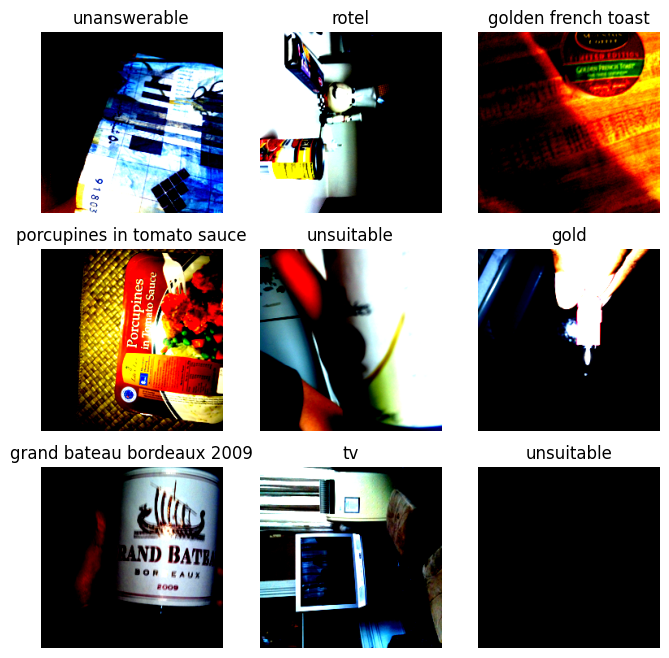

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(vqaTrain), size=(1,)).item()
    image, question, answer, answer_type = vqaTrain[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(vqaDataset.answer_corpus[answer])
    plt.axis("off")
    plt.imshow(image.squeeze().permute(1, 2, 0), cmap="gray")
plt.show()

In [7]:
class VQA_MODEL(nn.Module):
    def __init__(self,clipModel):
        super(VQA_MODEL, self).__init__()
        self.clipModel = clipModel
        self.fc1 = nn.Linear(in_features=1024, out_features=4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.ln1 = nn.LayerNorm(4096)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(in_features=4096, out_features=2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.ln2 = nn.LayerNorm(2048)
        self.dropout2 = nn.Dropout(0.5)
        
        self.aux = nn.Linear(in_features=4096, out_features=answer_type_size)
        self.auxbn = nn.BatchNorm1d(answer_type_size)
        self.auxln = nn.LayerNorm(answer_type_size)
        self.auxdropout = nn.Dropout(0.5)
        
        self.ans = nn.Linear(in_features=2048, out_features=answer_size)
        self.ansbn = nn.BatchNorm1d(answer_size)
        self.ansln = nn.LayerNorm(answer_size)
        
        self.answerMask = nn.Linear(in_features=answer_type_size, out_features=answer_size)
        self.answerMaskbn = nn.BatchNorm1d(answer_size)
        self.answerMaskln = nn.LayerNorm(answer_size)
        self.answerMaskdropout = nn.Dropout(0.5)
        
        
        self.activation = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputImg,inputText):
        with torch.no_grad():
            ImgVec = self.clipModel.encode_image(inputImg.squeeze(1))
            TextVec = self.clipModel.encode_text(inputText.squeeze(1))
        inputx = torch.cat((ImgVec,TextVec),1)
    
        inputx = inputx.to(torch.float32)
    
        inputx = self.fc1(inputx)
        inputx = self.bn1(inputx)
        inputx = self.ln1(inputx)
        inputx = self.activation(inputx)
        inputx = self.dropout1(inputx)
        
        
        input2 = self.fc2(inputx)
        input2 = self.bn2(input2)
        input2 = self.ln2(input2)
        input2 = self.activation(input2)
        input2 = self.dropout2(input2)
        
        inputAux = self.aux(inputx)
        inputAux = self.auxbn(inputAux)
        inputAux = self.auxln(inputAux)
        inputAux = self.activation(inputAux)
        inputAux = self.auxdropout(inputAux)
        
        inputMask = self.answerMask(inputAux)
        inputMask = self.answerMaskbn(inputMask)
        inputMask = self.answerMaskln(inputMask)
        inputMask = self.sigmoid(inputMask)
        inputMask = self.answerMaskdropout(inputMask)
        
        Ans = self.ans(input2)
        
        return Ans,inputAux


In [8]:
from tqdm.notebook import tqdm
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    trainloader = torch.utils.data.DataLoader(vqaTrain, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    for i, data in enumerate(tqdm(trainloader)):
        # Every data instance
        image, question, answer, answer_type = data[0].to(device), data[1].to(device), data[2].to(device),data[3].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        
        
        # Compute the loss and its gradients
        AnsOutputs,typeOuts = model(image,question)
        loss = criterion(AnsOutputs, answer)
        Typeloss = Typecriterion(typeOuts, answer_type)
        loss = loss + Typeloss
        
        loss.backward()
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))

    return last_loss

In [9]:
model = VQA_MODEL(clipModel).to(device)

In [10]:
import torch.optim as optim
import datetime
batch_size = 32
num_epochs = 10
best_vloss = 1_000_000.
epoch_number = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Typecriterion = nn.CrossEntropyLoss()

valloader = torch.utils.data.DataLoader(vqaVal, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
for i in range(num_epochs):
    print('EPOCH {}:'.format(epoch_number + 1))
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    
    running_vloss = 0.0
    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(valloader):
            image, question, answer, answer_type = vdata[0].to(device), vdata[1].to(device), vdata[2].to(device),vdata[3].to(device)
            vAnsoutputs,vTypeoutputs = model(image, question)
            vAnsloss = criterion(vAnsoutputs, answer)
            running_vloss += vAnsloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(datetime.datetime.now(), epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 8.193053097724915
  batch 200 loss: 15.51540274620056
  batch 300 loss: 22.680619850158692
  batch 400 loss: 29.695100564956665
  batch 500 loss: 36.5684597826004
LOSS train 36.5684597826004 valid 5.7997145652771
EPOCH 2:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 6.1521934270858765
  batch 200 loss: 12.58661171913147
  batch 300 loss: 19.042292618751524
  batch 400 loss: 25.58032100200653
  batch 500 loss: 32.08358759403229
LOSS train 32.08358759403229 valid 5.7332658767700195
EPOCH 3:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 5.419542374610901
  batch 200 loss: 11.136260182857514
  batch 300 loss: 16.77385303735733
  batch 400 loss: 22.580028741359712
  batch 500 loss: 28.393903720378876
LOSS train 28.393903720378876 valid 5.90710973739624
EPOCH 4:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 4.419000444412231
  batch 200 loss: 9.012866408824921
  batch 300 loss: 13.700914287567139
  batch 400 loss: 18.506258137226105
  batch 500 loss: 23.218809134960175
LOSS train 23.218809134960175 valid 5.954473495483398
EPOCH 5:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 3.153926148414612
  batch 200 loss: 6.563532037734985
  batch 300 loss: 10.189849815368653
  batch 400 loss: 13.867580692768097
  batch 500 loss: 17.743630154132845
LOSS train 17.743630154132845 valid 6.321058750152588
EPOCH 6:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 2.343188477754593
  batch 200 loss: 4.834722864627838
  batch 300 loss: 7.447893586158752
  batch 400 loss: 10.216734658479691
  batch 500 loss: 13.139660140275955
LOSS train 13.139660140275955 valid 6.690396308898926
EPOCH 7:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 1.9528928351402284
  batch 200 loss: 4.020125395059585
  batch 300 loss: 6.232614749670029
  batch 400 loss: 8.521446832418441
  batch 500 loss: 10.902431740760804
LOSS train 10.902431740760804 valid 7.123855113983154
EPOCH 8:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 1.7740847659111023
  batch 200 loss: 3.6141579031944273
  batch 300 loss: 5.506368412971496
  batch 400 loss: 7.467759529352188
  batch 500 loss: 9.533194552659989
LOSS train 9.533194552659989 valid 7.1711554527282715
EPOCH 9:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 1.6692131507396697
  batch 200 loss: 3.3642345893383028
  batch 300 loss: 5.137487456798554
  batch 400 loss: 7.036808779239655
  batch 500 loss: 8.954213210344314
LOSS train 8.954213210344314 valid 7.700588703155518
EPOCH 10:


  0%|          | 0/532 [00:00<?, ?it/s]

  batch 100 loss: 1.5304048609733583
  batch 200 loss: 3.1940060663223266
  batch 300 loss: 4.948017966747284
  batch 400 loss: 6.706350082159043
  batch 500 loss: 8.543238970041275
LOSS train 8.543238970041275 valid 7.839015960693359


In [11]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.8 MB/s eta 0:00:00


In [12]:
import torch
from tqdm.notebook import tqdm
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassF1Score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
compute_frequency = 2
epoch = 0
metric_ans = MulticlassAccuracy(device=device)
metric_type = MulticlassAccuracy(device=device)
f1_ans = MulticlassF1Score(num_classes=len(vqaDataset.answer_corpus),device=device)
f1_type = MulticlassF1Score(num_classes=len(vqaDataset.answer_type_corpus),device=device)

testloader = torch.utils.data.DataLoader(vqaTest, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
model.eval()
with torch.no_grad():
    for batch_idx, vdata in enumerate(tqdm(testloader)):
        image, question, answer, answer_type = vdata[0].to(device), vdata[1].to(device), vdata[2].to(device),vdata[3].to(device)
        Ansoutputs,Typeoutputs = model(image, question)
        metric_ans.update(Ansoutputs, answer)
        metric_type.update(Typeoutputs, answer_type)
        f1_ans.update(Ansoutputs, answer)
        f1_type.update(Typeoutputs, answer_type)
        
        if (batch_idx + 1) % compute_frequency == 0:
                print(
                    "Batch {} --- Answer acc: {:.4f} --- Type acc: {:.4f} --- Answer f1: {:.4f} --- Type f1: {:.4f}".format(
                        batch_idx + 1,
                        # metric.compute() returns metric value from all seen data
                        metric_ans.compute(),
                        metric_type.compute(),
                        f1_ans.compute(),
                        f1_type.compute()
                    )
                )

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  0%|          | 0/32 [00:00<?, ?it/s]

Batch 2 --- Answer acc: 0.3281 --- Type acc: 0.6094 --- Answer f1: 0.3281 --- Type f1: 0.6094
Batch 4 --- Answer acc: 0.3125 --- Type acc: 0.7031 --- Answer f1: 0.3125 --- Type f1: 0.7031
Batch 6 --- Answer acc: 0.3229 --- Type acc: 0.7500 --- Answer f1: 0.3229 --- Type f1: 0.7500
Batch 8 --- Answer acc: 0.3320 --- Type acc: 0.7695 --- Answer f1: 0.3320 --- Type f1: 0.7695
Batch 10 --- Answer acc: 0.3250 --- Type acc: 0.7531 --- Answer f1: 0.3250 --- Type f1: 0.7531
Batch 12 --- Answer acc: 0.3125 --- Type acc: 0.7578 --- Answer f1: 0.3125 --- Type f1: 0.7578
Batch 14 --- Answer acc: 0.3259 --- Type acc: 0.7612 --- Answer f1: 0.3259 --- Type f1: 0.7612
Batch 16 --- Answer acc: 0.3125 --- Type acc: 0.7578 --- Answer f1: 0.3125 --- Type f1: 0.7578
Batch 18 --- Answer acc: 0.3177 --- Type acc: 0.7569 --- Answer f1: 0.3177 --- Type f1: 0.7569
Batch 20 --- Answer acc: 0.3266 --- Type acc: 0.7672 --- Answer f1: 0.3266 --- Type f1: 0.7672
Batch 22 --- Answer acc: 0.3239 --- Type acc: 0.7713 -